<a href="https://colab.research.google.com/github/prcm066/cancer_detection_example/blob/main/CNN_Twitter_Disaster_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing with Disaster Tweets



## 1. Introduction

We are tackling the problem of classifying tweets as either disaster-related or non-disaster-related, as part of the "Natural Language Processing with Disaster Tweets" competition. The goal is to build an ML model capable of identifying tweets that announce real emergencies.

I propose a Bi-directional Long Short-term memory architecture to tackle this task.

Here we are only mounting and unzipping the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp "/content/drive/My Drive/nlp-getting-started.zip" /content/
!unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!pip install kaggle numpy pandas matplotlib seaborn wordcloud nltk tensorflow keras-tuner

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import re

In [10]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## 2. Exploratory Data Analysis

Training samples: 7613
Test samples: 3263

Missing values:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


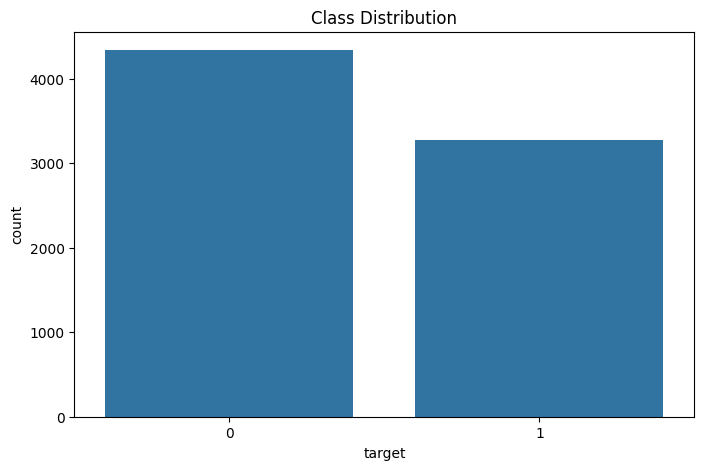

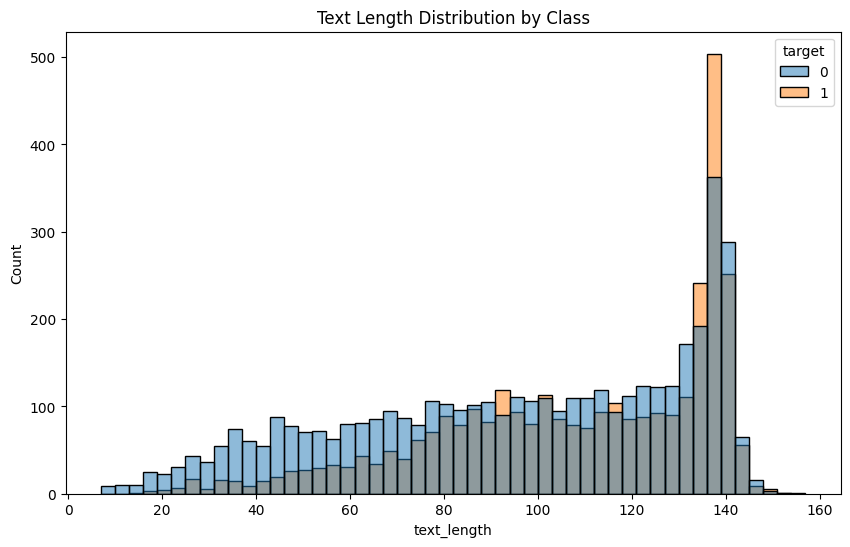

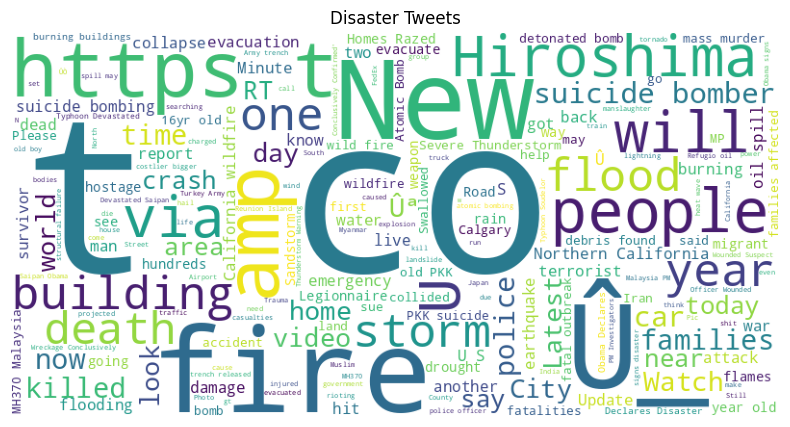

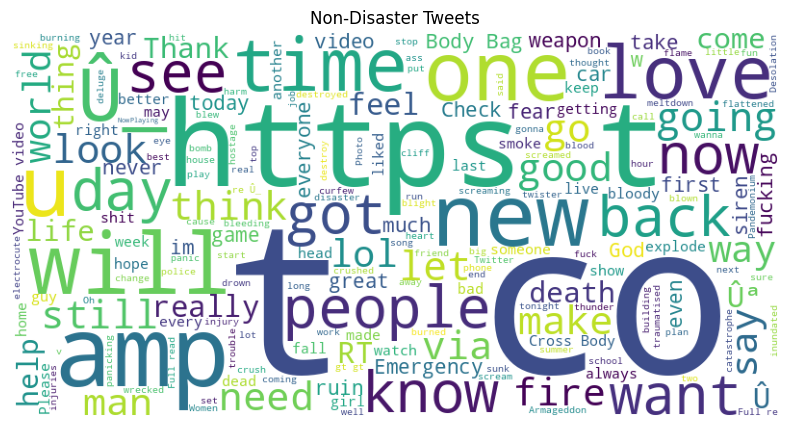

In [11]:
# Basic statistics
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print("\nMissing values:")
print(train_df.isnull().sum())

# Target distribution
plt.figure(figsize=(8,5))
sns.countplot(x='target', data=train_df)
plt.title('Class Distribution')
plt.show()

# Text length analysis
train_df['text_length'] = train_df['text'].apply(len)
plt.figure(figsize=(10,6))
sns.histplot(data=train_df, x='text_length', hue='target', bins=50, alpha=0.5)
plt.title('Text Length Distribution by Class')
plt.show()

# Word clouds
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis('off')

disaster_tweets = ' '.join(train_df[train_df['target']==1]['text'])
non_disaster_tweets = ' '.join(train_df[train_df['target']==0]['text'])

plot_wordcloud(disaster_tweets, 'Disaster Tweets')
plot_wordcloud(non_disaster_tweets, 'Non-Disaster Tweets')

### 2.1 EDA summary of fidnings

In the statistics and visualizations below we can identify the following:


*   The dataset is balanced in the target variable
*   While both classes have a mode at 140 characters, The real disaster tweets tend to be longer that the non-disaster related tweets.





## 3. Data Preprocessing

The Data preprocessing consists of two main functions run in sequence

Tonkenization.

1.   Tokenizer
2.   Custom Text Cleaning function



**1. TweetTokenizer**

The TweetTokenizer is specifically designed for Twitter text, with settings tailored to handle its unique characteristics:

preserve_case=False: Converts all text to lowercase to ensure uniformity.

reduce_len=True: Reduces repeated characters in words (e.g., "loooove" → "loove") to normalize informal spellings.

strip_handles=False: Retains Twitter handles (e.g., @user) to preserve social context.

match_phone_numbers=False: Prevents the tokenizer from collapsing phone numbers into a single token.

**2. Custom Cleaning Function (twitter_clean):**

URL Replacement: All URLs (e.g., http://example.com) are replaced with a placeholder [URL] to reduce noise and focus on textual content.

Number Replacement: All numeric values are replaced with a placeholder [NUMBER] to generalize numerical information.

Tokenization: The cleaned text is tokenized using the TweetTokenizer, which splits the text into individual tokens (words or symbols) while preserving hashtags and mentions.

In [12]:
from nltk.tokenize import TweetTokenizer
import re

# Initialize tokenizer with Twitter-aware settings
tweet_tokenizer = TweetTokenizer(
    preserve_case=False,       # Lowercase
    reduce_len=True,            # Replace repeated chars (e.g., "loooove" → "loove")
    strip_handles=False,        # Keep @ mentions
    match_phone_numbers=False   # Don't collapse phone numbers
)

def twitter_clean(text):
    # Keep hashtags and mentions
    text = re.sub(r"http\S+", "[URL]", text)  # Replace URLs
    text = re.sub(r"\d+", "[NUMBER]", text)   # Replace numbers
    return " ".join(tweet_tokenizer.tokenize(text))

# Apply to dataset
train_df['processed'] = train_df['text'].apply(twitter_clean)
test_df['processed'] = test_df['text'].apply(twitter_clean)

# Tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['processed'])

train_sequences = tokenizer.texts_to_sequences(train_df['processed'])
test_sequences = tokenizer.texts_to_sequences(test_df['processed'])

max_length = 50
X_train = pad_sequences(train_sequences, maxlen=max_length, padding='post')
X_test = pad_sequences(test_sequences, maxlen=max_length, padding='post')
y_train = train_df['target'].values

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

## 4. Model Building

### 4.1 Model Architecture (Bidirectional LSTM)

Our proposed architecture consists of the following

* **Embedding Layer:**

Converts text into dense, low-dimensional vectors, capturing semantic relationships between words.

This step is essential for handling the high-dimensional and sparse nature of text data.

* **Bidirectional LSTM:*

LSTMs are specifically designed for sequential data like text, as they can capture long-term dependencies.

Bidirectionality allows the model to consider both past and future context, improving its understanding of the text.

* **Dropout:**

This liayer purpose is regularization. It is essential to prevent overfitting, to which Deep Learning models are succeptible due to their large number of parameters.

* **Hyperparameter Tuning:**

The parametrs to be fine tuned are indicated in the code by Keras Tuner calls (indicated by hp.Int and hp.Float) we will use random search as our HP tuning strategy.

In [13]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=10000,
                      output_dim=hp.Int('embed_dim', 64, 256, step=64),
                      input_length=max_length))
    model.add(Bidirectional(LSTM(units=hp.Int('lstm_units', 64, 256, step=64),
                          return_sequences=False)))
    model.add(Dropout(hp.Float('dropout', 0.3, 0.7, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model


### 4.2 Hyperparameter tuning

In [14]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='tuning',
    project_name='disaster_tweets')

early_stop = EarlyStopping(monitor='val_loss', patience=3)

tuner.search(X_train, y_train,
            epochs=20,
            validation_data=(X_val, y_val),
            callbacks=[early_stop])

# Get optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal embedding dim: {best_hps.get('embed_dim')}")
print(f"Optimal LSTM units: {best_hps.get('lstm_units')}")

# Train final model
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train,
                   epochs=20,
                   validation_data=(X_val, y_val),
                   callbacks=[early_stop])

Trial 10 Complete [00h 00m 25s]
val_accuracy: 0.8056467473506927

Best val_accuracy So Far: 0.8092580437660217
Total elapsed time: 00h 04m 17s
Optimal embedding dim: 128
Optimal LSTM units: 192
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6600 - loss: 0.6051 - val_accuracy: 0.7472 - val_loss: 0.5120
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8604 - loss: 0.3407 - val_accuracy: 0.7938 - val_loss: 0.4597
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9212 - loss: 0.2147 - val_accuracy: 0.7623 - val_loss: 0.5058
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9408 - loss: 0.1639 - val_accuracy: 0.7768 - val_loss: 0.6678
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9575 - loss: 0.1192 - val_accuracy: 0.7656 - val_loss: 0.6075


In [14]:
print(best_hps)

In [15]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 50, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 384)                 │         493,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             385 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,320,325 (20.30 MB)

 Trainable params: 1,773,441 (6.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,546,884 (13.53 MB)

## 5. Results and Analysis

As we can see in the charts, the model plateaus at a validation accuracy ~ 0.80, while the training accuracy keeps climbing.

This suggests that additional steps to prevent overfitting may be necessary. We could explore different regularization strategies, or explore finetuning the parameters with an expanded droput rate range.



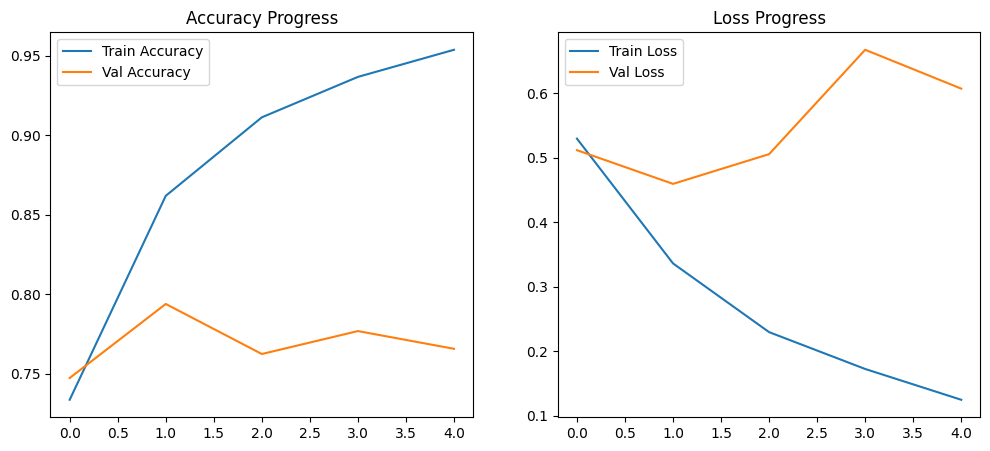

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [16]:

# Training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Progress')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Progress')
plt.legend()
plt.show()

# Generate predictions
submission = pd.read_csv('sample_submission.csv')
submission['target'] = model.predict(X_test).round().astype(int)
submission.to_csv('submission.csv', index=False)


In [17]:
history.history['accuracy']

[0.7334975600242615,
 0.8619047403335571,
 0.9113300442695618,
 0.9367815852165222,
 0.9538587927818298]